### Single transmon optimisation
Single transmon with five energy levels. The lowest four levels are being used for storing two qubits. The generation creates a superposition of 2 LOs and envelopes. Single- and two-qubit gates can be optimised.

In [1]:
import os, sys, argparse
from collections import OrderedDict

# Main C3 objects
import numpy as np

from c3.libraries import constants
from c3.parametermap import ParameterMap as PMap
from c3.experiment import Experiment as Exp
from c3.model import Model as Mdl
from c3.utils.tf_utils import tf_project_to_comp

# Building blocks
import c3.generator.devices as devices
import c3.signal.gates as gates
import c3.libraries.chip as chip
import c3.signal.pulse as pulse
import c3.libraries.tasks as tasks

# Libs and helpers
import c3.libraries.algorithms as algorithms
import c3.libraries.fidelities as fidelities
import c3.utils.qt_utils as qt_utils
from c3.optimizers.optimalcontrol import OptimalControl

#%matplotlib widget

from four_level_transmons.utilities import *
from four_level_transmons.plotting import *
from four_level_transmons.custom_envelopes import *
from four_level_transmons.DataOutput import DataOutput
from four_level_transmons.notebook_utils import *

import four_level_transmons.custom_gates as custom_gates
from c3.utils import tf_utils
tf.config.run_functions_eagerly(True)
tf.get_logger().setLevel('ERROR')
np.set_printoptions(linewidth=300)

2023-10-24 14:31:57.208048: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-24 14:31:57.208075: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
if len(sys.argv[1:]) > 0 and "ipykernel_launcher" not in sys.argv[0]:
    parser = argparse.ArgumentParser()
    parser.add_argument("--output", help="Output directory")
    args = parser.parse_args()
    output_dir = args.output
    print("Output directory: ", output_dir)
else:
    print("=========== WARNING: no output directory specified ============")
    output_dir = "./output"

=========== WARNING: no output directory specified ============


In [24]:
numPWCPieces = 60
usePWC = False
useDRAG = True
t_final = 40e-9 #1e-11
sim_res = 100e9 #1000e9
awg_res = numPWCPieces / t_final if usePWC else 20e9 #1000e9
USE_COMPLEX_GAUSSIANS = False
USE_COMPLEX_AMPLITUDE = False

ideal_gate, ideal_gate_name = qt_utils.np_kron_n([constants.GATES["rz90p"], constants.Id]), "rz90p_q1"
#ideal_gate, ideal_gate_name = qt_utils.np_kron_n([constants.Id, constants.GATES["rz90p"]]), "rz90p_q2"
#ideal_gate, ideal_gate_name = qt_utils.np_kron_n([constants.Id, constants.H]), "Z_q1"
#ideal_gate, ideal_gate_name = np.array([[1, 0, True0, 0], [0, 0, 1, 0], [0, 1, 0, 0], [0, 0, 0, 1]]) / np.sqrt(2.0), "swap"
#ideal_gate, ideal_gate_name = np.array([[1,0,0,-1j], [0,1,-1j,0], [0,-1j,1,0], [-1j,0,0,1]]) / np.sqrt(2.0), "double_iswap"
#ideal_gate, ideal_gate_name = constants.ISWAP, "iswap"

INPUT_FILE = "./optimised_params/single transmon/2 LOs/rz90p_q1_40ns.json"

algorithm = algorithms.lbfgs
algorithmParameters = {"maxfun": 1000, "ftol": 1e-8}

#algorithm = algorithms.cmaes
#algorithmParameters = {"popsize": 10, "maxfevals": 10000, "init_point": "True", "tolfun": 0.01, "spread": 0.25}

In [25]:
def stateEntropy(state: tf.Tensor):
    rho = densityMatrix(state)
    rho = tf_project_to_comp(rho, dims=[5], outdims=[4])
    #rhoBD = partialTrace(rho, [1, 3])
    rhoB = partialTrace(rho, [1])
    return entanglementEntropy(rhoB)


def printEntanglementEvolution(exper: Experiment, gate: gates.Instruction, output: DataOutput):
    entropies = []
    #for state in [(0, 1), (0, 5), (1, 6), (5, 6)]:
    #    psi_init = np.zeros(shape=(model.tot_dim,))
    #    psi_init[state[0]] = psi_init[state[1]] = 1 / np.sqrt(2)
    #    entropy = calculateObservable(exper, np.array(psi_init), [gate.get_key()], stateEntropy)
    #    entropies.append(entropy)
    psi_init = np.zeros(shape=(model.tot_dim,))
    psi_init[0] = 1.0 #psi_init[2] = 1.0 / np.sqrt(2.0)
    entropy = calculateObservable(exper, np.array(psi_init), [gate.get_key()], stateEntropy)
    np.save(output.createFileName('entanglement'), [exper.ts.numpy(), entropy])
    plotPopulation(exper, np.array([entropy]), sequence=[gate.get_key()],
                   labels=["00+01", "00+10", "01+11", "10+11"],
                   filename=output.createFileName("entanglement", "svg"),
                   labelY="Entropy")

In [41]:
# Initialise the qubits and drive lines
qubit_levels = 5
qubit_frequency = 6e9
anharmonicity = -250e6

t1 = 25e-6
t2star = 35e-6
qubit_temp = 50e-3
output = DataOutput(output_dir, file_suffix='before')
qubit = createQubits([qubit_levels], [qubit_frequency], [anharmonicity], [t1], [t2star], qubit_temp)[0]
drive = createDrives([qubit])[0]

# Create the model
model = Mdl([qubit], [drive])
model.set_lindbladian(False)
model.set_dressed(False)
model.set_FR(False)
energies = getEnergiesFromHamiltonian(qubit.get_Hamiltonian())
print("energies: ", energies)
transitions = np.array([energies[i + 1] - energies[i] for i in range(len(energies) - 1)])
print("transition frequencies: ", transitions)

energies:  [0.000e+00 6.000e+09 1.175e+10 1.725e+10 2.250e+10]
transition frequencies:  [6.00e+09 5.75e+09 5.50e+09 5.25e+09]


In [49]:
generator = createGeneratorNLOs([drive], sim_res=sim_res, awg_res=awg_res, N=2)

# Envelopes and carriers
#carrier_freqs = [transitions[0], transitions[2]]
carrier_freqs = [0.5 * (transitions[0] + transitions[1]), 0.5 * (transitions[1] + transitions[2])]
#carrier_freqs = [4.7e9]#, 4.543e9]
print("Carrier frequencies: ", carrier_freqs)
#carrier_freqs = [transitions[0], transitions[2]]
#carrier_freqs = [4.854e+09, 4.545e+09]
deltaFreq = 1e9
deltaAnh = 50e6
#shifts = [deltaFreq, deltaFreq + 2 * deltaAnh]
shifts = [deltaFreq + 0.5 * deltaAnh, deltaFreq + 1.5 * deltaAnh]

pulse_t_final = [t_final, t_final]
pulse_sigmasR = [t_final / 5, t_final / 5]
pulse_sigmasI = [t_final / 5, t_final / 5]
#integrated_amp = np.sqrt(np.pi/2) / (pulse_t_final * 1e9)
#pulse_amps = [integrated_amp, 0.7 * integrated_amp]  #[0.06, 0.03]
pulse_amps = [0.6, 0.5]
#pulse_deltas = [-0.053766, -0.019014] #[1e-5, 1e-5]
pulse_deltas = [-0.07, 0.04]
pulse_xy_angles = [-1.1, 0.8]
pulse_freq_offsets = [1e-5, 1e-5]  #[0.5e6, 0.5e6]

envelopes = []
carriers = []

if False:
    for i in range(0, len(carrier_freqs)):
        if USE_COMPLEX_GAUSSIANS:
            gaussian_envelope = createComplexGaussianPulse(
                t_final=pulse_t_final[i],
                sigmaR=pulse_sigmasR[i],
                sigmaI=pulse_sigmasI[i],
                amp=1.0 if USE_COMPLEX_AMPLITUDE else pulse_amps[i],
                ampR=pulse_amps[i] / np.sqrt(2) if USE_COMPLEX_AMPLITUDE else None,
                ampI=pulse_amps[i] / np.sqrt(2) if USE_COMPLEX_AMPLITUDE else None,
                delta=pulse_deltas[i],
                xy_angle=pulse_xy_angles[i],
                freq_off=pulse_freq_offsets[i],
                useDrag=useDRAG
            )
        else:
            gaussian_envelope = createGaussianPulse(
                t_final=pulse_t_final[i],
                sigma=pulse_sigmasR[i],
                amp=pulse_amps[i],
                delta=pulse_deltas[i],
                xy_angle=pulse_xy_angles[i],
                freq_off=pulse_freq_offsets[i],
                useDrag=useDRAG,
            )
        gaussian_envelope.name = f"envelope_d1_{i + 1}"
        envelopes.append(gaussian_envelope)

        carrier_parameters = {
            "freq": Qty(value=carrier_freqs[i], min_val=0.9 * carrier_freqs[i], max_val=1.1 * carrier_freqs[i],
                        unit="Hz 2pi"),
            "framechange": Qty(value=0, min_val=-np.pi, max_val=3 * np.pi, unit="rad"),
        }
        carriers.append(pulse.Carrier(
            name=f"carrier_d1_{i + 1}",
            desc="Frequency of the local oscillator",
            params=carrier_parameters,
        ))
else:
    stored_pmap = PMap()
    stored_pmap.read_config(INPUT_FILE)
    stored_params = stored_pmap.asdict()[ideal_gate_name + "[0]"]
    stored_params_d = stored_params["drive_channels"]["d1"]
    for i in range(len(carrier_freqs)):
        env = stored_params_d[f"envelope_d1_{i + 1}"]
        env.params["t_final"] = Qty(value=t_final, min_val=0.8 * t_final, max_val=t_final, unit="s")

        if useDRAG and type(env) is not pulse.EnvelopeDrag:
            env = convertToDRAG(env)
        elif not useDRAG and type(env) is pulse.EnvelopeDrag:
            env = convertFromDRAG(env)
        envelopes.append(env)

        carrier = stored_params_d[f"carrier_d1_{i + 1}"]
        #carrier.params['freq'] = Qty(value=carrier_freqs[i], min_val=0.8 * carrier_freqs[i],
        #                             max_val=1.2 * carrier_freqs[i],
        #                             unit=carrier.params['freq'].unit)
        #oldValue = carrier.params['freq'].get_value() / (2 * np.pi)
        #carrier.params['freq'].set_value(oldValue + 1e9)
        #carrier.params['freq'] = shiftQuantity(carrier.params['freq'], 1e9)
        #if i == 1:
        #    carrier.params['freq'] = shiftQuantity(carrier.params['freq'], 100e6)
        carrier.params['freq'] = shiftQuantity(carrier.params['freq'], shifts[i])
        carriers.append(carrier)

print("Carriers: ", [c.params["freq"] for c in carriers])
print("Amps: ", [e.params["amp"] for e in envelopes])

Carrier frequencies:  [5875000000.000001, 5624999999.999998]
Carriers:  [5.825 GHz 2pi, 5.553 GHz 2pi]
Amps:  [493.813 mV, 451.581 mV]


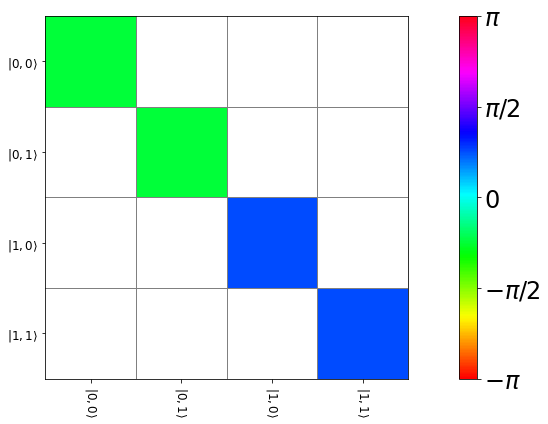

In [50]:
# Gate instructions
printMatrix(ideal_gate, createSingleTransmonQubitLabels(4, makeLatexKets=True), "ideal_gate", output)

gate = gates.Instruction(
    name=ideal_gate_name,
    targets=[0],
    t_start=0.0,
    t_end=t_final,
    channels=[drive.name],
    ideal=ideal_gate,
)
for env in envelopes:
    gate.add_component(copy.deepcopy(env), drive.name)
for carrier in carriers:
    gate.add_component(copy.deepcopy(carrier), drive.name)

peaks: d1
	1.460183e+10 (amp=3.158960e+08)
	1.450181e+10 (amp=3.185701e+08)
	1.437680e+10 (amp=3.329994e+08)
	2.557820e+10 (amp=3.522789e+08)
	1.415177e+10 (amp=4.748104e+08)
	1.442680e+10 (amp=5.277769e+08)
	5.425678e+09 (amp=1.566300e+09)
	5.625703e+09 (amp=6.759733e+09)
	5.550694e+09 (amp=5.007986e+11)
	5.825728e+09 (amp=7.502199e+11)


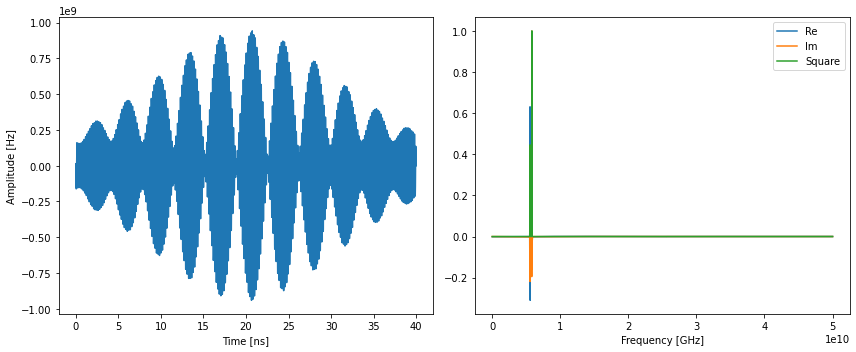

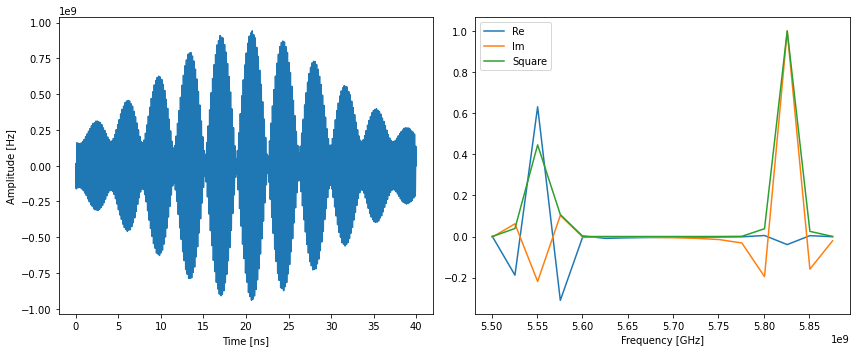

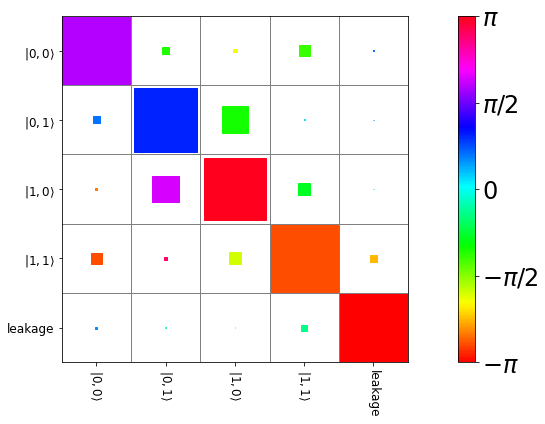

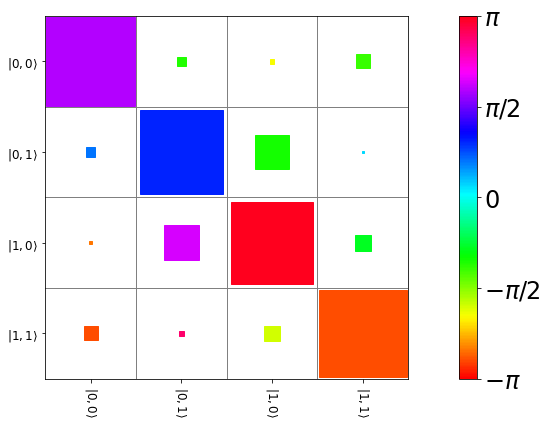

In [51]:
# Set up the experiment
parameter_map = PMap(instructions=[gate], model=model, generator=generator)
exp = Exp(pmap=parameter_map)
exp.set_opt_gates([gate.get_key()])

stateEnergies = getEnergiesFromHamiltonian(model.get_Hamiltonian())
transitionLabels = calculateTransitions(stateEnergies, createSingleTransmonQubitLabels(5, makeLatexKets=True))
generator.generate_signals(gate)
#print(generator.getDeviceOutput("d1", "AWG1"))
printSignal(exp, [qubit], gate, output=output, states=transitionLabels)

unitaries = exp.compute_propagators()
printPropagator(exp, gate, createSingleTransmonQubitLabels(5, makeLatexKets=True, labelLeakageAsNumbers=False), createSingleTransmonQubitLabels(4, makeLatexKets=True), output)
#printAllSignals(exp, qubit, output, directory="devices_before")rz90p_q2_40ns

In [52]:
# Calculate and save the time-dependent Hamiltonian
signal = parameter_map.generator.generate_signals(parameter_map.instructions[gate.get_key()])
H = parameter_map.model.get_Hamiltonian(signal)
output.save(H, 'hamiltonian_timedependent')

In [53]:
initialFidelity = 1 - tf_utils.tf_unitary_overlap(tf_project_to_comp(
        unitaries[gate.get_key()], dims=[5], index=[0], outdims=[4]
    ), ideal_gate, lvls=4).numpy()
print("Initial infidelity: ", initialFidelity)

Initial infidelity:  [0.23179099]


In [ ]:
# Specify the initial state
psi_init = [[0] * model.tot_dim]
psi_init[0][0] = 1.0 #psi_init[0][1] = psi_init[0][2] = psi_init[0][3] = 1.0 / 2
print(psi_init)
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))
sequence = [gate.get_key()]

#printTimeEvolution(exp, init_state, gate, createSingleTransmonQubitLabels(5, makeLatexKets=True, labelLeakageAsNumbers=False), output)
#printEntanglementEvolution(exp, gate, output)
parameter_map.write_config(output.createFileName('parameter_map', 'json'))

In [ ]:
# Specify the parameters to be optimised and initialise the optimiser
opt_map = []
for env in envelopes:
    if USE_COMPLEX_GAUSSIANS:
        opt_map.append([(gate.get_key(), "d1", env.name, "sigmaR")])
        opt_map.append([(gate.get_key(), "d1", env.name, "sigmaI")])
    else:
        opt_map.append([(gate.get_key(), "d1", env.name, "sigma")])
    if USE_COMPLEX_AMPLITUDE:
        opt_map.append([(gate.get_key(), "d1", env.name, "ampR")])
        opt_map.append([(gate.get_key(), "d1", env.name, "ampI")])
    else:
        opt_map.append([(gate.get_key(), "d1", env.name, "amp")])
    #opt_map.append([(gate.get_key(), "d1", env.name, "freq_offset")])
    opt_map.append([(gate.get_key(), "d1", env.name, "xy_angle")])
    opt_map.append([(gate.get_key(), "d1", env.name, "t_final")])
    if useDRAG:
        opt_map.append([(gate.get_key(), "d1", env.name, "delta")])
for carrier in carriers:
    opt_map.append([(gate.get_key(), "d1", carrier.name, "freq")])
#    #opt_map.append([(gate.get_key(), "d1", carrier.name, "framechange")])
parameter_map.set_opt_map(opt_map)
parameter_map.print_parameters()

In [ ]:
infidelities = optimise(output, [qubit], exp, algorithm, algorithmParameters, gate)
#infidelities = optimise(output, qubit, exp, algorithms.cmaes, {"popsize": 12, "spread": 0.05}, gate)

In [ ]:
# Plot results
output = DataOutput(output_dir, file_suffix='after')
plotData(np.arange(len(infidelities)), infidelities, xlabel="Step",
         ylabel="Infidelity", filename=output.createFileName("convergence", "svg"))
printSignal(exp, [qubit], gate, output=output, states=transitionLabels)
#printAllSignals(exp, qubit, output, directory="devices_after")
printPropagator(exp, gate, createSingleTransmonQubitLabels(5, makeLatexKets=True, labelLeakageAsNumbers=False), createSingleTransmonQubitLabels(4, makeLatexKets=True), output)
#printTimeEvolution(exp, init_state, gate, createSingleTransmonQubitLabels(5, makeLatexKets=True, labelLeakageAsNumbers=False), output)
#printEntanglementEvolution(exp, gate, output)
parameter_map.write_config(output.createFileName('parameter_map', 'json'))

'''
propagator = np.load('propagator_after.npy')
labels = ["|0,0\\rangle", "|0,1\\rangle", "|1,0\\rangle", "|1,1\\rangle", "leakage"]
labels = [f"${s}$" for s in labels]
plotComplexMatrixHinton(propagator, maxAbsolute=1, xlabels=labels, ylabels=labels, gridColour="gray",
                        filename=None, colourMap='hsv')
'''